In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
coin = 'KRW-HIFI'

In [4]:
df = pd.read_csv(f'../data/from_pyupbit/{coin}.csv')

In [5]:
df

,timestamp,open,high,low,close,volume,value
0,2020-12-10 01:57:00,254.0,255.0,254.0,255.0,3873.036000,9.874796e+05
1,2020-12-10 02:11:00,255.0,255.0,255.0,255.0,218.823529,5.580000e+04
2,2020-12-10 02:13:00,255.0,255.0,255.0,255.0,37.679200,9.608196e+03
3,2020-12-10 02:15:00,255.0,255.0,255.0,255.0,120.180791,3.064610e+04
4,2020-12-10 02:19:00,256.0,256.0,256.0,256.0,39.062500,1.000000e+04
...,...,...,...,...,...,...,...
1576795,2024-10-12 22:58:00,714.4,716.2,714.4,715.0,2590.098116,1.850538e+06
1576796,2024-10-12 22:59:00,714.5,714.5,714.3,714.3,10993.691322,7.854553e+06
1576797,2024-10-12 23:00:00,714.3,714.5,713.6,714.5,17747.861990,1.267516e+07
1576798,2024-10-12 23:01:00,716.1,717.5,716.1,717.5,44247.438822,3.172240e+07


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [7]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2020-12-10 01:57:00,254.0,255.0,254.0,255.0,3873.036000,9.874796e+05
2020-12-10 02:11:00,255.0,255.0,255.0,255.0,218.823529,5.580000e+04
2020-12-10 02:13:00,255.0,255.0,255.0,255.0,37.679200,9.608196e+03
2020-12-10 02:15:00,255.0,255.0,255.0,255.0,120.180791,3.064610e+04
2020-12-10 02:19:00,256.0,256.0,256.0,256.0,39.062500,1.000000e+04
...,...,...,...,...,...,...
2024-10-12 22:58:00,714.4,716.2,714.4,715.0,2590.098116,1.850538e+06
2024-10-12 22:59:00,714.5,714.5,714.3,714.3,10993.691322,7.854553e+06
2024-10-12 23:00:00,714.3,714.5,713.6,714.5,17747.861990,1.267516e+07


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, f'models/{coin}_scaler.pkl')

['models/KRW-HIFI_scaler.pkl']

In [9]:
timestep = 1

In [10]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [11]:
X, y = np.array(X), np.array(y)

In [12]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
39420/39420 [==============================] - 646s 16ms/step - loss: 3.5923e-05 - val_loss: 3.4991e-07
Epoch 2/20
39420/39420 [==============================] - 620s 16ms/step - loss: 3.4937e-06 - val_loss: 1.4474e-06
Epoch 3/20
39420/39420 [==============================] - 602s 15ms/step - loss: 3.1716e-06 - val_loss: 2.5773e-06
Epoch 4/20
39420/39420 [==============================] - 602s 15ms/step - loss: 3.0591e-06 - val_loss: 1.4537e-06
Epoch 5/20
39420/39420 [==============================] - 623s 16ms/step - loss: 2.9440e-06 - val_loss: 4.6375e-07
Epoch 6/20
39420/39420 [==============================] - 612s 16ms/step - loss: 2.8382e-06 - val_loss: 1.1842e-06
Epoch 7/20
39420/39420 [==============================] - 628s 16ms/step - loss: 2.8203e-06 - val_loss: 3.2298e-06
Epoch 8/20
39420/39420 [==============================] - 616s 16ms/step - loss: 2.7576e-06 - val_loss: 5.6934e-07
Epoch 9/20
39420/39420 [==============================] - 617s 16ms/step - loss:

In [19]:
model.save(f'models/lstm_{coin}.h5')

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9855/9855 [==============================] - 48s 5ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [22]:
test_predict

array([[983.9609],
       [983.9609],
       [983.9609],
       ...,
       [715.5604],
       [714.8598],
       [715.06  ]], dtype=float32)

In [23]:
y_test

array([[983. , 983. , 984. , ..., 714.3, 714.5, 717.5]])

In [24]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 5.62
Test RMSE: 2.49


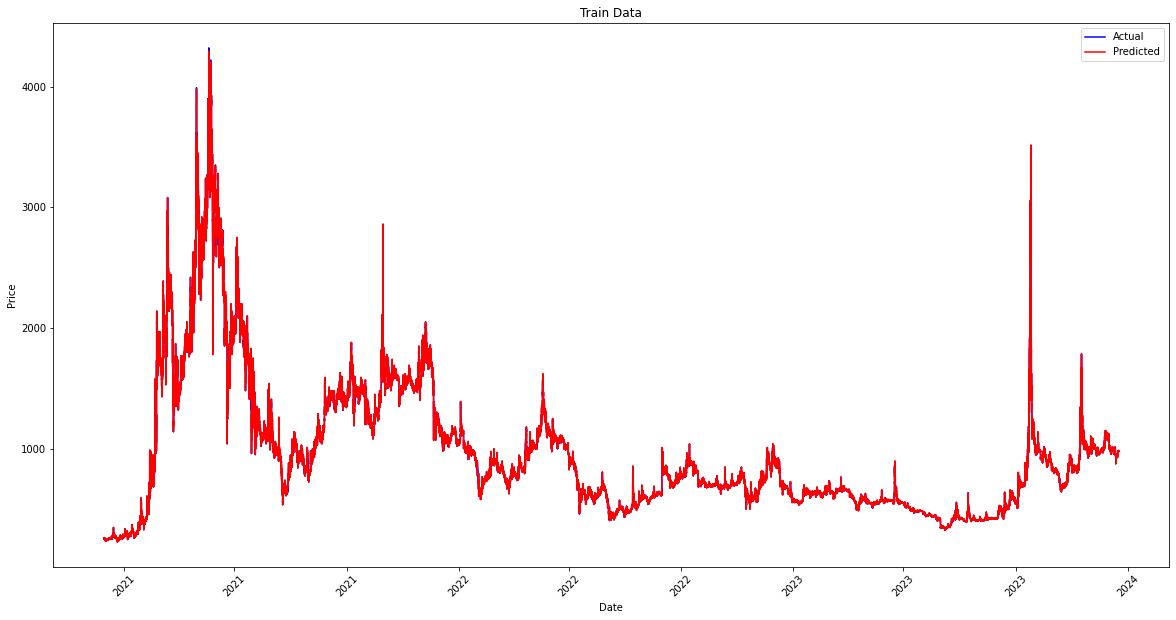

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

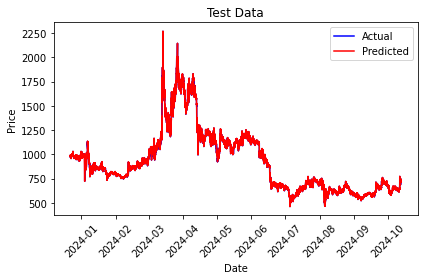

In [27]:
plt.subplot(1, 1, 1)
plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [28]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.11983875]]


In [29]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 14ms/step
[[718.0625]]


In [30]:
preds = []
for i in range(30):
    pred = model.predict(X_predict)
    preds.append(scaler.inverse_transform(pred)[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


In [31]:
preds

[718.0625,
 718.6254,
 719.1889,
 719.75287,
 720.3173,
 720.88226,
 721.4477,
 722.0136,
 722.5801,
 723.147,
 723.7144,
 724.28235,
 724.85077,
 725.41974,
 725.9892,
 726.5592,
 727.1297,
 727.70074,
 728.2723,
 728.84436,
 729.41705,
 729.9902,
 730.56384,
 731.13806,
 731.7128,
 732.28815,
 732.864,
 733.4404,
 734.0174,
 734.5949]